# 4SELECCION_ACTIVOS: SELECCIÓN ÓPTIMA DE ACTIVOS PARA OPTIMIZACIÓN DE CARTERAS

Este notebook demuestra el funcionamiento del módulo `4seleccion_activos`, que implementa estrategias de selección de activos basadas en la frontera de diversificación para mejorar la eficiencia de la optimización de Markowitz.

## Objetivos del Notebook

1. **Detección de N Óptimo**: Identificar automáticamente cuántos activos se necesitan para diversificación óptima
2. **Cálculo de Métricas**: Evaluar calidad de cada activo (Sharpe Ratio, volatilidad, correlación)
3. **Selección de Activos**: Seleccionar N activos óptimos balanceando Sharpe Ratio alto y baja correlación
4. **Optimización Completa**: Ejecutar pipeline completo de selección + optimización Markowitz
5. **Vector de Pesos Final**: Obtener vector de 50 posiciones con pesos optimizados
6. **Visualización**: Crear visualizaciones completas del proceso de selección
7. **Comparación de Estrategias**: Comparar equiponderada 50, Markowitz 50, y Selección+Markowitz N

## Conexión con Módulos Anteriores

- **Módulo 1 (`1datos`)**: Carga y prepara datos de retornos
- **Módulo 2 (`2equiponderada_diversificacion`)**: Detecta N óptimo usando frontera de diversificación
- **Módulo 3 (`3markowitz`)**: Optimiza cartera sobre activos seleccionados

Este módulo integra los insights de diversificación del módulo 2 con la optimización de Markowitz del módulo 3, seleccionando primero los mejores N activos antes de optimizar, lo cual puede mejorar significativamente el Sharpe Ratio final.

## 1. Imports y Configuración

Importamos las librerías necesarias y los módulos del proyecto. El módulo `4seleccion_activos` requiere de los módulos 1, 2 y 3 para funcionar correctamente.

In [1]:
import sys
import importlib
sys.path.append('../src')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Verificar si cvxpy está instalado (requerido para 3markowitz)
try:
    import cvxpy as cp
    cvxpy_instalado = True
except ImportError:
    cvxpy_instalado = False
    print("ADVERTENCIA: cvxpy no está instalado.")
    print("Para instalar cvxpy, ejecute: pip install cvxpy")
    print("O en una celda del notebook: !pip install cvxpy")

# Importar módulos (los nombres que empiezan con números requieren importlib)
datos = importlib.import_module('1datos')
equiponderada = importlib.import_module('2equiponderada_diversificacion')

if cvxpy_instalado:
    markowitz = importlib.import_module('3markowitz')
    seleccion = importlib.import_module('4seleccion_activos')
    print("Librerías importadas correctamente")
else:
    print("No se puede importar 3markowitz y 4seleccion_activos sin cvxpy instalado.")
    print("Por favor, instale cvxpy antes de continuar.")

# Configuración de visualización
plt.rcParams['figure.figsize'] = (14, 10)
plt.rcParams['font.size'] = 11

Librerías importadas correctamente


## 2. Carga de Datos

Cargamos los datos históricos de retornos diarios usando el módulo `1datos`. Estos datos son la base para todo el análisis de selección de activos.

In [2]:
print("="*80)
print("PASO 1: CARGA DE DATOS")
print("="*80)

ruta_csv = '../data/prod_long_sharpe_u50_20260116_v5_train_dataset.csv'
retornos = datos.cargar_retornos(ruta_csv)

print(f"\nDatos cargados: {retornos.shape[0]} días, {retornos.shape[1]} activos")
print(f"Rango temporal: día 0 a día {retornos.shape[0]-1}")

PASO 1: CARGA DE DATOS
Datos cargados: 1760 días, 50 activos

Datos cargados: 1760 días, 50 activos
Rango temporal: día 0 a día 1759


## 3. Detección de N Óptimo

Detectamos automáticamente cuántos activos se necesitan para alcanzar el límite práctico de diversificación usando la frontera de diversificación del módulo 2.

In [3]:
print("\n" + "="*80)
print("PASO 2: DETECCIÓN DE NÚMERO ÓPTIMO DE ACTIVOS")
print("="*80)

resultado_n = seleccion.detectar_n_optimo_activos(retornos, umbral_reduccion=2.0)
print(f"\nNúmero óptimo detectado: {resultado_n['n_optimo']} activos")
print(f"Reducción de riesgo en N óptimo: {resultado_n['reduccion_en_optimo']:.2f}%")
print(f"Volatilidad anualizada en N óptimo: {resultado_n['volatilidad_en_optimo']*100:.2f}%")


PASO 2: DETECCIÓN DE NÚMERO ÓPTIMO DE ACTIVOS

TABLA RESUMEN: FRONTERA DE DIVERSIFICACIÓN
  N |  Vol(%) |   ±Std |  Esp(%) |  Sis(%) |  Reduc
--------------------------------------------------------------------------------
  2 |   17.99 |   4.06 |   14.09 |   11.91 |    N/A
  3 |   16.43 |   3.01 |   11.74 |   11.89 |  8.67%
  4 |   15.69 |   2.89 |   10.30 |   12.17 |  4.55%
  5 |   14.52 |   2.21 |    8.89 |   11.68 |  7.47%
  6 |   14.43 |   2.04 |    8.38 |   11.92 |  0.58%
  7 |   13.84 |   1.74 |    7.62 |   11.69 |  4.07%
  8 |   14.05 |   1.64 |    7.23 |   12.16 | -1.46%
  9 |   13.86 |   1.60 |    6.87 |   12.14 |  1.36%
 10 |   13.33 |   1.40 |    6.49 |   11.73 |  3.76%
 12 |   13.04 |   1.38 |    5.83 |   11.75 |  2.20%
 15 |   12.69 |   1.13 |    5.19 |   11.63 |  2.71%
 20 |   12.67 |   0.82 |    4.51 |   11.87 |  0.13%
 25 |   12.58 |   0.62 |    4.09 |   11.92 |  0.69%
 30 |   12.45 |   0.55 |    3.71 |   11.90 |  1.03%
 40 |   12.21 |   0.35 |    3.20 |   11.79 |  1.

## 4. Cálculo de Métricas de Selección

Calculamos métricas de calidad para cada activo que servirán como criterios de selección: Sharpe Ratio, volatilidad, y correlación promedio.

In [4]:
print("\n" + "="*80)
print("PASO 3: MÉTRICAS DE CALIDAD DE ACTIVOS")
print("="*80)

metricas = seleccion.calcular_metricas_seleccion(retornos, rf_anual=0.02)
print("\nTop 10 activos por Sharpe Ratio:")
print(metricas.head(10).to_string())

print("\n\nEstadísticas generales:")
print(f"Sharpe promedio: {metricas['sharpe_ratio'].mean():.3f}")
print(f"Correlación promedio: {metricas['correlacion_promedio'].mean():.3f}")


PASO 3: MÉTRICAS DE CALIDAD DE ACTIVOS

Top 10 activos por Sharpe Ratio:
    activo  sharpe_ratio  rendimiento_anual  volatilidad_anual  correlacion_promedio  puntuacion_diversificacion
0   asset6      1.105209           0.134303           0.103600              0.540851                    0.459149
1  asset36      1.020255           0.176903           0.153981              0.477493                    0.522507
2   asset2      0.926320           0.145970           0.136202              0.547993                    0.452007
3   asset8      0.880639           0.123016           0.117202              0.420467                    0.579533
4  asset23      0.727346           0.120097           0.137890              0.262172                    0.737828
5  asset13      0.667037           0.132113           0.168371              0.490237                    0.509763
6  asset42      0.600629           0.097616           0.129553              0.383876                    0.616124
7  asset28      0.5828

## 5. Selección de Activos Óptimos

Seleccionamos N activos óptimos balanceando Sharpe Ratio alto y baja correlación, usando los criterios combinados.

In [5]:
print("\n" + "="*80)
print("PASO 4: SELECCIÓN DE ACTIVOS ÓPTIMOS")
print("="*80)

seleccion_resultado = seleccion.seleccionar_activos_por_sharpe_decorrelacion(
    retornos, 
    n_activos=resultado_n['n_optimo'],
    rf_anual=0.02,
    peso_sharpe=0.7,
    peso_decorrelacion=0.3
)

print(f"\nActivos seleccionados: {len(seleccion_resultado['activos_seleccionados'])}")
print(f"Lista: {seleccion_resultado['activos_seleccionados']}")
print(f"\nSharpe promedio de seleccionados: {seleccion_resultado['sharpe_promedio_seleccion']:.3f}")
print(f"Correlación promedio entre seleccionados: {seleccion_resultado['correlacion_promedio_seleccion']:.3f}")

print("\n\nMétricas detalladas de activos seleccionados:")
print(seleccion_resultado['metricas'].to_string())


PASO 4: SELECCIÓN DE ACTIVOS ÓPTIMOS

Activos seleccionados: 6
Lista: ['asset23', 'asset36', 'asset6', 'asset8', 'asset2', 'asset42']

Sharpe promedio de seleccionados: 0.877
Correlación promedio entre seleccionados: 0.623


Métricas detalladas de activos seleccionados:
    activo  sharpe_ratio  rendimiento_anual  volatilidad_anual  correlacion_promedio  puntuacion_diversificacion  score_combinado
0  asset23      0.727346           0.120097           0.137890              0.262172                    0.737828         0.759245
1  asset36      1.020255           0.176903           0.153981              0.477493                    0.522507         0.737229
2   asset6      1.105209           0.134303           0.103600              0.540851                    0.459149         0.730324
3   asset8      0.880639           0.123016           0.117202              0.420467                    0.579533         0.721629
4   asset2      0.926320           0.145970           0.136202              0.

### Gráfico rentabilidad-riesgo de los activos

Visualizamos la dispersión riesgo-rentabilidad de los activos antes de continuar con la optimización.

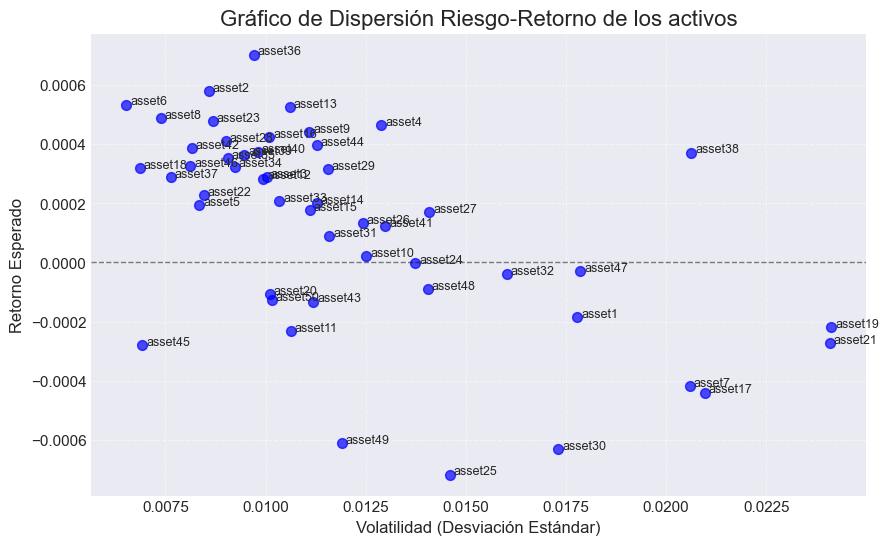

In [6]:
# Gráfico rentabilidad-riesgo de los activos
seleccion.graficar_rentabilidad_riesgo_activos(retornos)

## 6. Optimización Completa con Selección

Ejecutamos el pipeline completo: detección de N óptimo, selección de activos, filtrado de retornos, optimización con Markowitz, y reconstrucción del vector de 50 posiciones.

In [7]:
print("\n" + "="*80)
print("PASO 5: OPTIMIZACIÓN CON SELECCIÓN")
print("="*80)

resultado = seleccion.optimizar_cartera_con_seleccion(
    retornos,
    rf_anual=0.02,
    n_optimo=None,  # Auto-detectar
    umbral_reduccion=2.0,
    peso_sharpe=0.7,
    peso_decorrelacion=0.3
)

print(f"\nNúmero de activos utilizados: {resultado['n_activos_usados']}")
print(f"\nMétricas de la cartera optimizada:")
print(f"  Sharpe Ratio: {resultado['metricas_cartera']['sharpe']:.4f}")
print(f"  Rentabilidad esperada: {resultado['metricas_cartera']['rentabilidad']*100:.2f}%")
print(f"  Volatilidad: {resultado['metricas_cartera']['volatilidad']*100:.2f}%")

print(f"\n\nComparación vs Baseline (equiponderada 50 activos):")
print(f"  Mejora en Sharpe: {resultado['comparacion_baseline']['mejora_sharpe']*100:.2f}%")
print(f"  Mejora en Rentabilidad: {resultado['comparacion_baseline']['mejora_rentabilidad']*100:.2f}%")
print(f"  Reducción en Volatilidad: {resultado['comparacion_baseline']['reduccion_volatilidad']*100:.2f}%")


PASO 5: OPTIMIZACIÓN CON SELECCIÓN
Detectando número óptimo de activos...

TABLA RESUMEN: FRONTERA DE DIVERSIFICACIÓN
  N |  Vol(%) |   ±Std |  Esp(%) |  Sis(%) |  Reduc
--------------------------------------------------------------------------------
  2 |   17.99 |   4.06 |   14.09 |   11.91 |    N/A
  3 |   16.43 |   3.01 |   11.74 |   11.89 |  8.67%
  4 |   15.69 |   2.89 |   10.30 |   12.17 |  4.55%
  5 |   14.52 |   2.21 |    8.89 |   11.68 |  7.47%
  6 |   14.43 |   2.04 |    8.38 |   11.92 |  0.58%
  7 |   13.84 |   1.74 |    7.62 |   11.69 |  4.07%
  8 |   14.05 |   1.64 |    7.23 |   12.16 | -1.46%
  9 |   13.86 |   1.60 |    6.87 |   12.14 |  1.36%
 10 |   13.33 |   1.40 |    6.49 |   11.73 |  3.76%
 12 |   13.04 |   1.38 |    5.83 |   11.75 |  2.20%
 15 |   12.69 |   1.13 |    5.19 |   11.63 |  2.71%
 20 |   12.67 |   0.82 |    4.51 |   11.87 |  0.13%
 25 |   12.58 |   0.62 |    4.09 |   11.92 |  0.69%
 30 |   12.45 |   0.55 |    3.71 |   11.90 |  1.03%
 40 |   12.21 |   0.

## 7. Vector de Pesos Final

Inspeccionamos el vector de pesos final de 50 posiciones, donde solo los N activos seleccionados tienen peso mayor que cero.

In [ ]:
print("\n" + "="*80)
print("PASO 6: VECTOR DE PESOS FINAL (50 POSICIONES)")
print("="*80)

pesos_finales = resultado['pesos_completos']

print("\nVector completo de pesos (asset1 a asset50):")
# Separador con coma entre elementos, y sin punto en ceros
formateador = {
    "float_kind": lambda x: "0" if abs(x) < 1e-12 else f"{x:.8f}"
}
print(np.array2string(pesos_finales, separator=", ", formatter=formateador))

print("\n\nVerificaciones:")
print(f"  Longitud del vector: {len(pesos_finales)}")
print(f"  Suma de pesos: {np.sum(pesos_finales):.6f}")
print(f"  Número de activos con peso > 0: {np.sum(pesos_finales > 0)}")
print(f"  Peso mínimo (no cero): {pesos_finales[pesos_finales > 0].min():.6f}")
print(f"  Peso máximo: {pesos_finales.max():.6f}")

print("\n\nActivos con peso > 1%:")
for i, peso in enumerate(pesos_finales):
    if peso > 0.01:
        print(f"  asset{i+1}: {peso:.4f} ({peso*100:.2f}%)")


PASO 6: VECTOR DE PESOS FINAL (50 POSICIONES)

Vector completo de pesos (asset1 a asset50):
[0.        , 0.26380766, 0.        , 0.        , 0.        , 0.02844126,
 0.        , 0.24015954, 0.        , 0.        , 0.        , 0.        ,
 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ,
 0.        , 0.        , 0.        , 0.        , 0.10925307, 0.        ,
 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ,
 0.        , 0.        , 0.        , 0.        , 0.        , 0.00266365,
 0.        , 0.        , 0.        , 0.        , 0.        , 0.35567481,
 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ,
 0.        , 0.        ]


Verificaciones:
  Longitud del vector: 50
  Suma de pesos: 1.000000
  Número de activos con peso > 0: 6
  Peso mínimo (no cero): 0.002664
  Peso máximo: 0.355675


Activos con peso > 1%:
  asset2: 0.2638 (26.38%)
  asset6: 0.0284 (2.84%)
  asset8: 0.2402 (24.02%)
  asset23: 0.1093 (10.93%)
  ass

## 8. Visualización de Resultados

Creamos visualizaciones completas del proceso de selección y optimización con 4 subplots: distribución de pesos, métricas de activos, matriz de correlación, y comparación de carteras.


PASO 7: VISUALIZACIÓN DE RESULTADOS
Figura guardada en: outputs/modulo4_seleccion.png


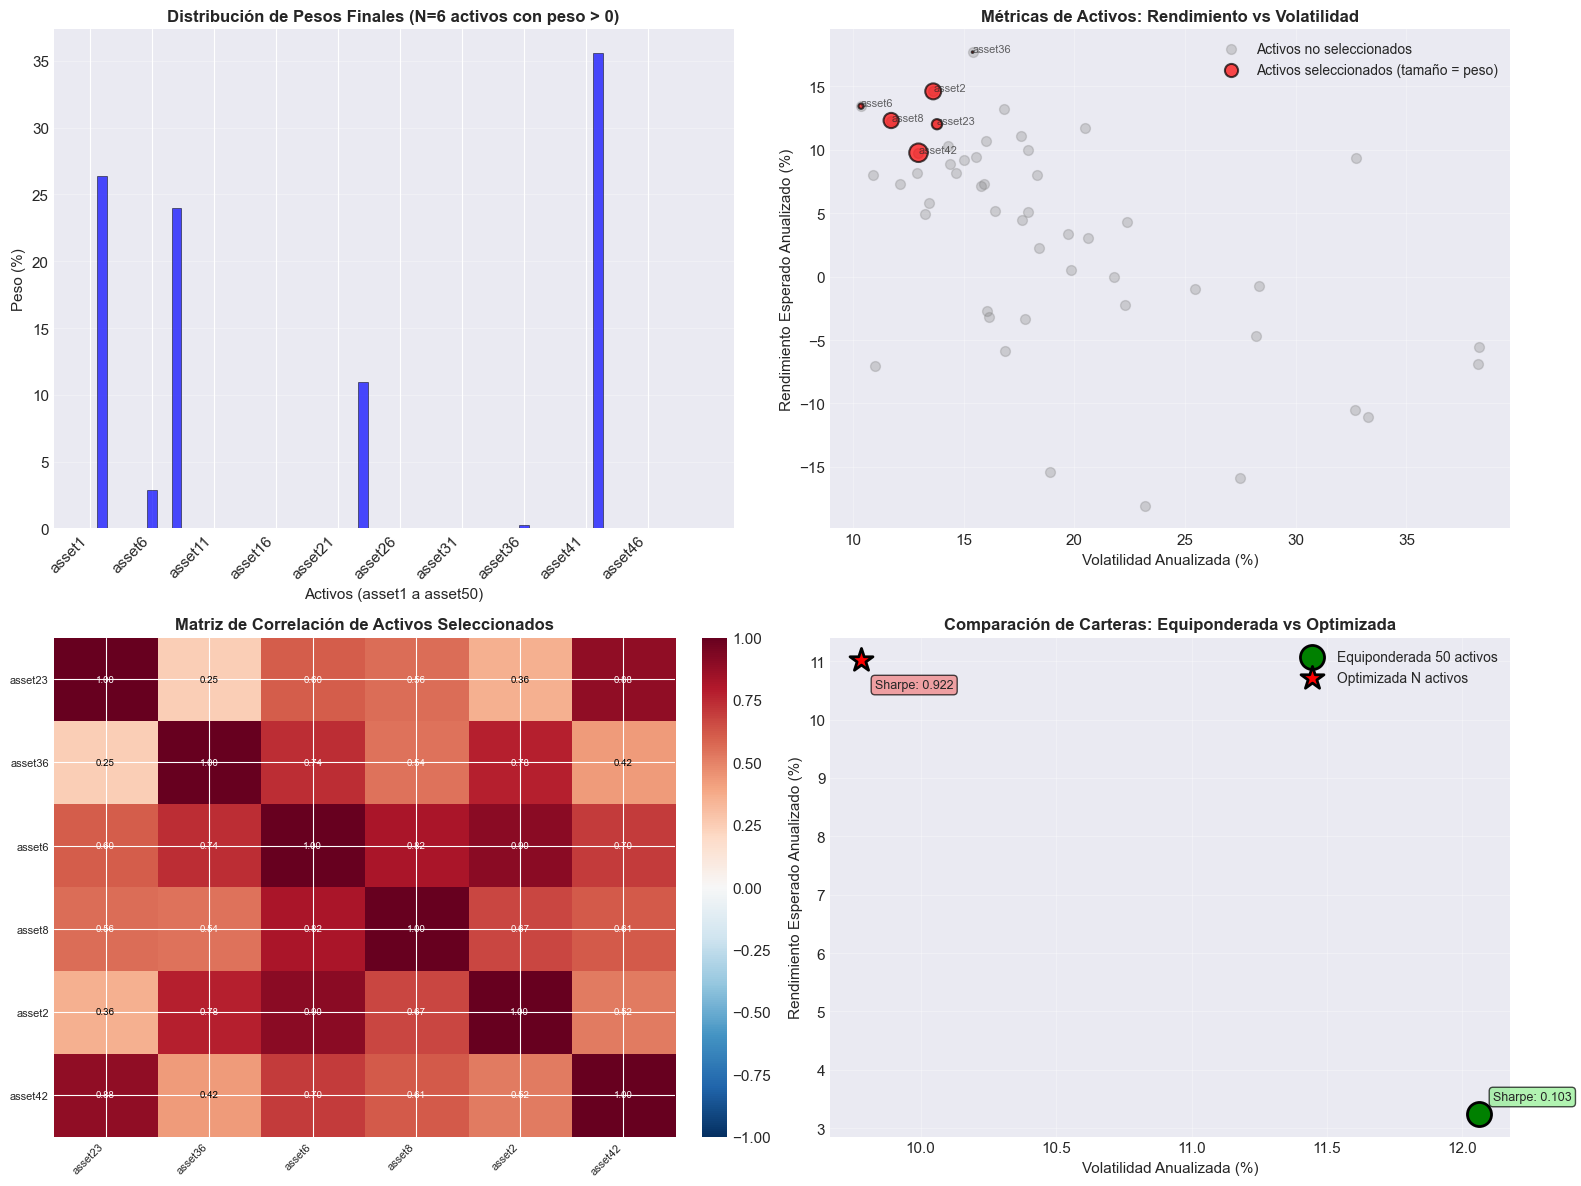


Figura guardada en: outputs/modulo4_seleccion.png


In [9]:
print("\n" + "="*80)
print("PASO 7: VISUALIZACIÓN DE RESULTADOS")
print("="*80)

fig = seleccion.visualizar_seleccion_activos(resultado, retornos, ruta_guardado='outputs/modulo4_seleccion.png')
plt.show()

print("\nFigura guardada en: outputs/modulo4_seleccion.png")

## 9. Comparación de Estrategias

Comparamos 3 estrategias diferentes:
1. **Equiponderada 50 activos**: Cartera simple con pesos iguales
2. **Markowitz 50 activos**: Optimización sobre todos los activos
3. **Selección + Markowitz N activos**: Selección previa + optimización


PASO 8: COMPARACIÓN DE ESTRATEGIAS
Estrategia 1: Cartera equiponderada de 50 activos...
Estrategia 2: Markowitz sobre 50 activos...
Estrategia 3: Selección + Markowitz sobre N activos...
Detectando número óptimo de activos...

TABLA RESUMEN: FRONTERA DE DIVERSIFICACIÓN
  N |  Vol(%) |   ±Std |  Esp(%) |  Sis(%) |  Reduc
--------------------------------------------------------------------------------
  2 |   17.99 |   4.06 |   14.09 |   11.91 |    N/A
  3 |   16.43 |   3.01 |   11.74 |   11.89 |  8.67%
  4 |   15.69 |   2.89 |   10.30 |   12.17 |  4.55%
  5 |   14.52 |   2.21 |    8.89 |   11.68 |  7.47%
  6 |   14.43 |   2.04 |    8.38 |   11.92 |  0.58%
  7 |   13.84 |   1.74 |    7.62 |   11.69 |  4.07%
  8 |   14.05 |   1.64 |    7.23 |   12.16 | -1.46%
  9 |   13.86 |   1.60 |    6.87 |   12.14 |  1.36%
 10 |   13.33 |   1.40 |    6.49 |   11.73 |  3.76%
 12 |   13.04 |   1.38 |    5.83 |   11.75 |  2.20%
 15 |   12.69 |   1.13 |    5.19 |   11.63 |  2.71%
 20 |   12.67 |   0.82 |

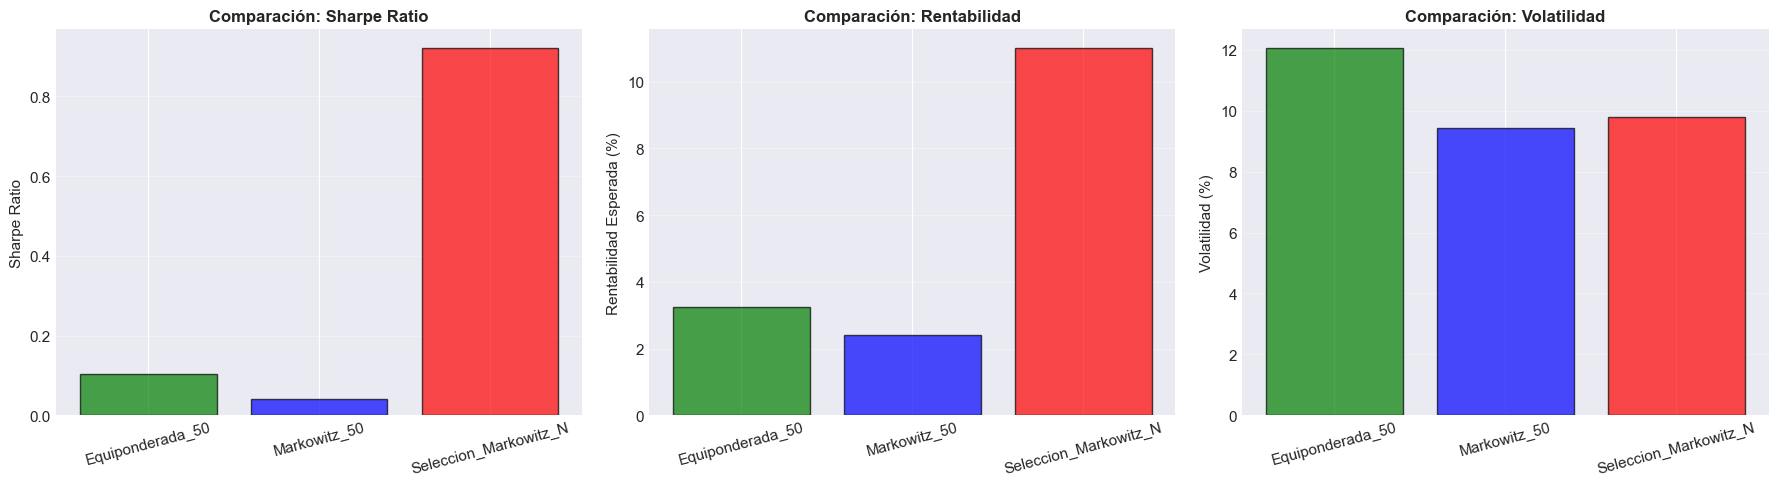

In [10]:
print("\n" + "="*80)
print("PASO 8: COMPARACIÓN DE ESTRATEGIAS")
print("="*80)

df_comparacion, fig_comparacion = seleccion.comparar_estrategias(retornos, rf_anual=0.02)

print("\nTabla comparativa:")
print(df_comparacion.to_string())

plt.show()

## 10. Exportar Vector de Pesos

Exportamos el vector de pesos final a CSV para su uso posterior.

In [11]:
print("\n" + "="*80)
print("PASO 9: EXPORTAR VECTOR DE PESOS")
print("="*80)

# Crear DataFrame con formato legible
df_pesos = pd.DataFrame({
    'activo': [f'asset{i+1}' for i in range(50)],
    'peso': pesos_finales,
    'porcentaje': pesos_finales * 100
})

# Guardar en CSV
df_pesos.to_csv('outputs/pesos_cartera_optimizada.csv', index=False)
print("\nVector de pesos guardado en: outputs/pesos_cartera_optimizada.csv")

# Mostrar solo activos con peso > 0
print("\n\nCartera final (solo activos seleccionados):")
print(df_pesos[df_pesos['peso'] > 0].to_string(index=False))


PASO 9: EXPORTAR VECTOR DE PESOS

Vector de pesos guardado en: outputs/pesos_cartera_optimizada.csv


Cartera final (solo activos seleccionados):
 activo     peso  porcentaje
 asset2 0.263808   26.380766
 asset6 0.028441    2.844126
 asset8 0.240160   24.015954
asset23 0.109253   10.925307
asset36 0.002664    0.266365
asset42 0.355675   35.567481


## Resumen

Este notebook ha demostrado el funcionamiento completo del módulo `4seleccion_activos`, que integra los insights de diversificación del módulo 2 con la optimización de Markowitz del módulo 3.

**Conclusiones principales**:
1. La selección previa de activos puede mejorar el Sharpe Ratio final
2. El número óptimo de activos (típicamente 15-25) permite alcanzar el límite práctico de diversificación
3. El balance entre Sharpe Ratio alto y baja correlación es crucial para una buena selección
4. El vector de pesos final de 50 posiciones se reconstruye correctamente, con solo N activos con peso > 0

**Próximo paso**: El módulo `4validacion` utilizará estos pesos optimizados para validar el rendimiento de la cartera en datos fuera de muestra.